# Live plotting with the data set context manager 

This notebook is adapted from "The Context Manager aka the Measurement Object" to show how to use the live plotter 

## Installation instructions: 

To install the live plotter, please run the following commands in the command prompt: 

```bash
git clone https://github.com/kouwenhovenlab/plottr.git
cd plottr
pip install -e .
```

## Basic instructions 

Add the following line to the imports in your code:

```python
from plottr.qcodes_dataset import QcodesDatasetSubscriber as LivePlotSubscriber
```

Then, right after starting the measurement context manager, add the following code 

```python
datasaver.dataset.subscribe(
   LivePlotSubscriber(datasaver.dataset),
   state=[], min_wait=0, min_count=1
)
```

This adds the live plotting subscriber to the data set.

Technical note: The live plot gets updated at the moments the data is flushed to the database (which is the current backend of the dataset), which is related to the `write_period` attribute of the `Measurement` class.

Technical note: The live plot subscriber needs the data set as an input argument so that it can know the parameter dependencies. This is needed to know what to plot against what.

## Example usage 

We use some of the examples from "The Context Manager aka the Measurement Object" from QCoDeS, and add the live plotting functionality to them. We also include examples for cases which are known not to work correctly with the live plotter.

In [1]:
%matplotlib notebook
import numpy.random as rd
import matplotlib.pyplot as plt
from functools import partial
import numpy as np

from time import sleep, monotonic

import qcodes as qc
from qcodes import Station
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)

from qcodes.dataset.database import initialise_database
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.param_spec import ParamSpec
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_export import get_shaped_data_by_runid

# Plive plotting specific imports 
import plottr
from plottr.qcodes_dataset import QcodesDatasetSubscriber as LivePlotSubscriber 

In [2]:
# Start the live plotting server 
plottr.start_listener()

In [3]:
# a generator to simulate a physical signal, in this case an exponentially
# decaying signal

def exponential_decay(a: float, b: float):
    """
    Yields a*exp(-b*x) where x is put in 
    """
    x = 0
    while True:
        x = yield
        yield a*np.exp(-b*x) + 0.02*a*np.random.randn()

In [4]:
# preparatory mocking of physical setup

dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrument('dmm', gates=['v1', 'v2'])

station = qc.Station(dmm, dac)

In [5]:
# and then a bit of "wiring" to make the dmm "measure"
# the exponential decay

ed = exponential_decay(5, 0.2)
next(ed)

def customgetter(dac):
    val = ed.send(dac.ch1())
    next(ed)
    return val
    
dmm.v1.get = partial(customgetter, dac)

In [6]:
# now make some silly set-up and tear-down actions

def veryfirst():
    print('Starting the measurement')

def numbertwo(inst1, inst2):
    print('Doing stuff with the following two instruments: {}, {}'.format(inst1, inst2))
    
def thelast():
    print('End of experiment')

### NB: database and experiments may be missing

If this is the first time you create a dataset, the underlying database file has
most likely not been created. The following cell creates the database file. Please
refer to documentation on `The Experiment Container` for details.

Furthermore, datasets are appended to existing experiments. If no experiment has been created,
we must create one.

In [7]:
initialise_database()
new_experiment(name='tutorial_exp', sample_name="no sample")

tutorial_exp#no sample#16@C:\Users\a-sochat/experiments.db
----------------------------------------------------------

In [9]:
# And then run an experiment

meas = Measurement()

meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))  # now register the dependent one

meas.add_before_run(veryfirst, ())  # add a set-up action
meas.add_before_run(numbertwo, (dmm, dac))  # add another set-up action
meas.add_after_run(thelast, ())  # add a tear-down action

meas.write_period = 2

with meas.run() as datasaver:
    
    # Add live plotting functionality
    datasaver.dataset.subscribe(
        LivePlotSubscriber(datasaver.dataset),
        state=[], min_wait=0, min_count=1
    )
             
    for set_v in np.linspace(0, 25, 1000):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))
        
        # We introduce a sleep so we can admire the live plotting functionality :-)
        sleep(0.1)
    
    dataid = datasaver.run_id  # convenient to have for plotting


Starting the measurement
Doing stuff with the following two instruments: <DummyInstrument: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 216
End of experiment


## Some 2D examples

In [19]:
# For the 2D, we'll need a new batch of parameters, notably one with two 
# other parameters as setpoints. We therefore define a new Measurement
# with new parameters

meas = Measurement()
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dac.ch2)  # register the second independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1, dac.ch2))  # now register the dependent oone

In [20]:
# and we'll make a 2D gaussian to sample from/measure
def gauss_model(x0: float, y0: float, sigma: float, noise: float=0.0005):
    """
    Returns a generator sampling a gaussian. The gaussian is
    normalised such that its maximal value is simply 1
    """
    while True:
        (x, y) = yield
        model = np.exp(-((x0-x)**2+(y0-y)**2)/2/sigma**2)*np.exp(2*sigma**2)
        noise = np.random.randn()*noise
        yield model + noise

In [21]:
# and finally wire up the dmm v1 to "measure" the gaussian

gauss = gauss_model(0.1, 0.2, 0.25)
next(gauss)

def measure_gauss(dac):
    val = gauss.send((dac.ch1.get(), dac.ch2.get()))
    next(gauss)
    return val

dmm.v1.get = partial(measure_gauss, dac)

In [22]:
# run a 2D sweep

with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        LivePlotSubscriber(datasaver.dataset),
        state=[], min_wait=0, min_count=1
    )

    for v1 in np.linspace(-1, 1, 200):
        for v2 in np.linspace(-1, 1, 200):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v1.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val))
            
    dataid = datasaver.run_id

Starting experimental run with id: 225


# What does not work? 

## Why some live plots fail 

Currently, the live plot only supports 1D data and some kinds of 2D data. 

### 1D data

Plotting 1D data is supported, except when the values on the independent axis are not unique. For example, suppose we want to make a hysteresis plot of a pinch off curve. We sweep the voltage from 0 to -4V and measure the current. At -4V we sweep back to 0V. This means that we will have multiple entries at 0V, 1V etc along the x-axis. This is not currently supported.

### 2D data 

2D data which is supported needs to be on a regular grid with equidistant spacing between the coordinate points. Data points with "holes" are not (properly) supported, and neither are randomely sampled X-Y points.

Additionally, the following coordinate layout is not supported:

```
-->x-x-x-x-x
           |
x-x-x-x-x<--
|
-->x-x-x-x-x
```

That is, when the fast axis reaches the end value of the sweep and the slow axis progresses one set point, the fast axis will  start the sweep at the maximum value and progress to the minimum value, creating a zig-zag pattern. 

Lets do this in code...

In [24]:
from qcodes import Parameter

x = Parameter("x", set_cmd=None, get_cmd=None)
y = Parameter("y", set_cmd=None, get_cmd=None)
m = Parameter("m", get_cmd=lambda: x()**2 + y()**2)

meas = Measurement()
meas.register_parameter(x)
meas.register_parameter(y)
meas.register_parameter(m, setpoints=(x, y))

with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        LivePlotSubscriber(datasaver.dataset),
        state=[], min_wait=0, min_count=1
    )

    for count, xvalue in enumerate(np.linspace(0, 1, 100)): 
        
        x.set(xvalue)

        if count % 2: 
            yvalues = np.linspace(1, 0, 100)
        else: 
            yvalues = np.linspace(0, 1, 100)

        for yvalue in yvalues: 
            
            y.set(yvalue)
            
            datasaver.add_result(
                (x, xvalue), 
                (y, yvalue), 
                (m, m.get())
            )

Starting experimental run with id: 227


We see that a weird checker board pattern emerges. The source of this bug is currently being investigated 

## Data with holes are not supported either 

We will see from the next example that data sets with large gaps in the coorindate points are not supported either

In [25]:
# or even perform an adaptive sweep... ooohh...
#
# This example is a not-very-clever toy model example,
# but it nicely shows a semi-realistic measurement that the old qc.Loop
# could not handle

meas = Measurement()
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dac.ch2)  # register the second independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1, dac.ch2))  # now register the dependent oone

v1_points = np.linspace(-1, 1, 250)
v2_points = np.linspace(1, -1, 250)

threshold = 0.25

with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        LivePlotSubscriber(datasaver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    # Do normal sweeping until the peak is detected
    
    for v2ind, v2 in enumerate(v2_points):
        for v1ind, v1 in enumerate(v1_points):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v1.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val))
            if val > threshold:
                break
        else:
            continue
        break
        
    # now be more clever, meandering back and forth over the peak
    doneyet = False
    rowdone = False
    v1_step = 1
    while not doneyet:
            v2 = v2_points[v2ind]
            v1 = v1_points[v1ind+v1_step-1]
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v1.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val))
            if val < threshold:
                if rowdone:
                    doneyet = True
                v2ind += 1
                v1_step *= -1
                rowdone = True
            else:
                v1ind += v1_step
                rowdone = False
                
dataid = datasaver.run_id

Starting experimental run with id: 228


We see that only the top part of the plot, there the coordinate points lie in a grid, are plotted. But this is what the complete plot is supposed to look like.  

<IPython.core.display.Javascript object>


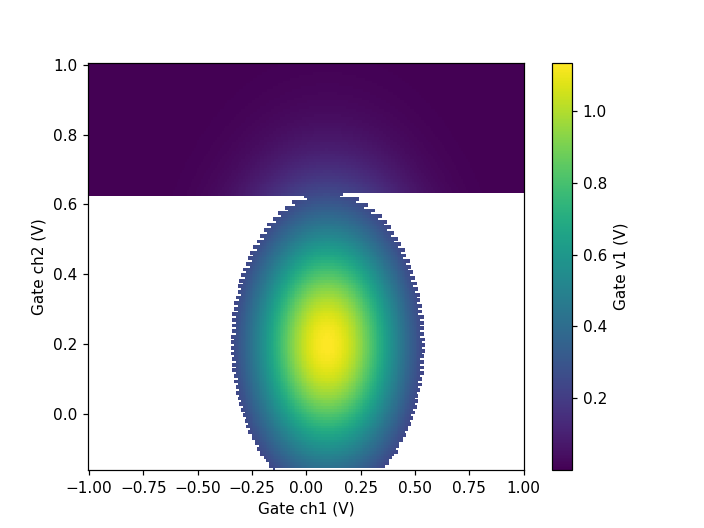

In [26]:
ax, cbax = plot_by_id(dataid)

## Random sampling 

This does not work too well with the live plotter, either 

In [27]:
gauss = gauss_model(0.1, 0.2, 0.25)
next(gauss)

def measure_gauss(x, y):
    val = gauss.send((x, y))
    next(gauss)
    return val

In [29]:
v1_points = np.linspace(-1, 1, 250)
v2_points = np.linspace(1, -1, 250)

threshold = 0.25

npoints = 10000

with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        LivePlotSubscriber(datasaver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(npoints):
        x = 2*(np.random.rand()-.5)
        y = 2*(np.random.rand()-.5)
        z = measure_gauss(x,y)
        datasaver.add_result((dac.ch1, x),
                     (dac.ch2, y),
                     (dmm.v1, z))
dataid = datasaver.run_id

Starting experimental run with id: 230


We see that most data points are not drawn. Out data set should look like 

<IPython.core.display.Javascript object>


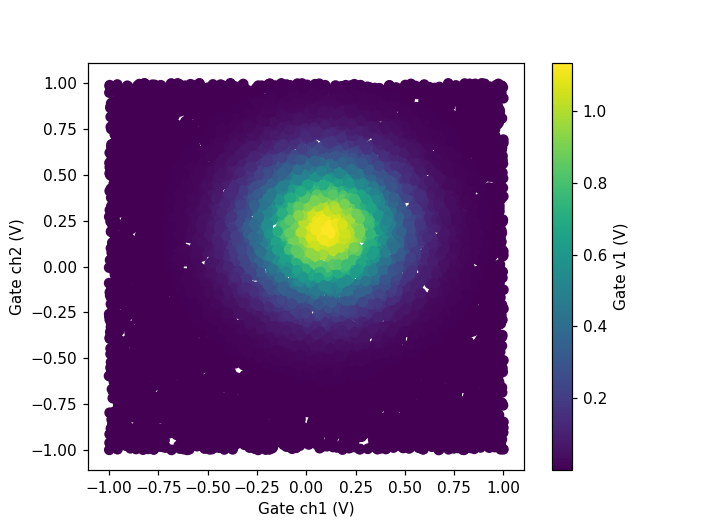

In [30]:
ax, cbax = plot_by_id(dataid)